In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "COVID-19_Radiography_Dataset"

In [4]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 613436.47it/s]


In [5]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [6]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [7]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 21165/21165 [00:15<00:00, 1327.02it/s]

             Class  Black & White  Colored
0           Normal          10192        0
1     Lung_Opacity           6012        0
2  Viral Pneumonia           1205      140
3            COVID           3616        0


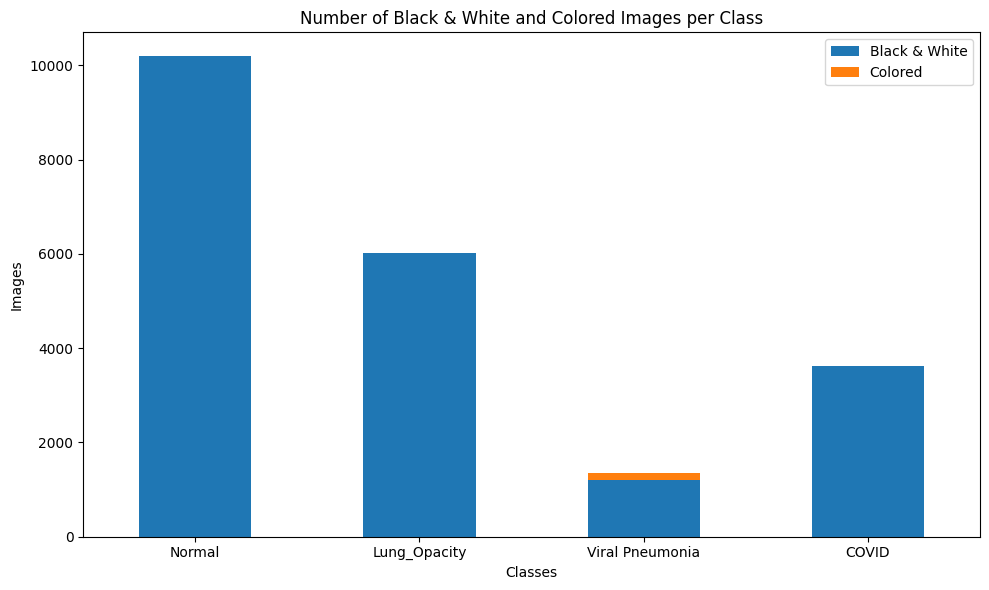

In [8]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 261.83it/s]


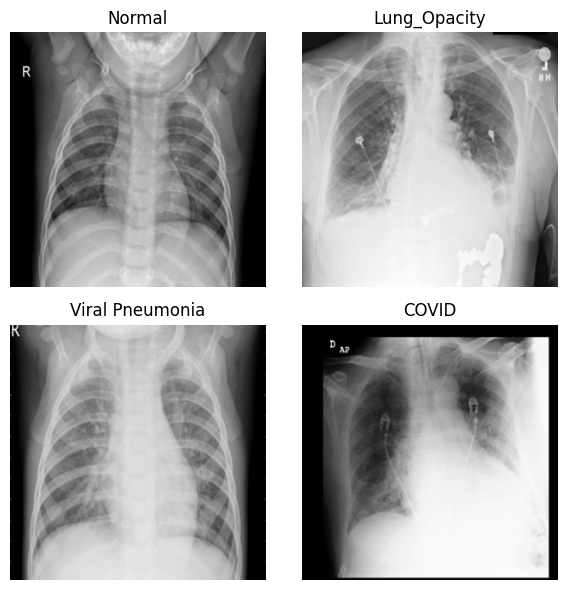

In [9]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 4/4 [00:20<00:00,  5.06s/it]


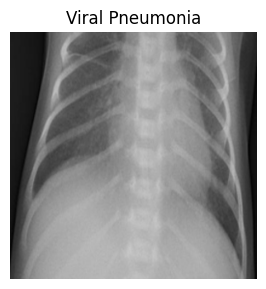

In [10]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [11]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.0808080808,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.0879120879,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 17743
Total Validation Samples: 1711
Total Test Samples: 1711

Percentage of Split:
Train: 83.83%
Validation: 8.08%
Test: 8.08%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    3032                 292           292
Lung_Opacity              5040                 486           486
Viral Pneumonia           8544                 824           824
COVID                     1127                 109           109


In [12]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [13]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(
        degrees=10, 
        translate=(0.1, 0.1), 
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [14]:
class PneuNet(nn.Module):
    def __init__(self, num_classes=3, freeze_backbone=False, input_channels=1, use_80_tokens=True):
        """
        PneuNet-like model with improvements:
        
        Parameters:
          - num_classes (int): Number of output classes.
          - freeze_backbone (bool): If True, freeze ResNet backbone parameters.
          - input_channels (int): Number of channels in input images (e.g., 1 for grayscale, 3 for RGB).
          - use_80_tokens (bool): If True, use AdaptiveAvgPool2d to produce 80 tokens (10x8); 
                                  otherwise, use the native 7x7 tokens for efficiency.
        """
        super(PneuNet, self).__init__()
        
        # Load a pretrained ResNet-18 backbone
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # If input_channels != 3, modify the first conv layer
        if input_channels != 3:
            resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Truncate ResNet to obtain the spatial feature map (7x7) from layer4
        self.backbone = nn.Sequential(
            resnet.conv1,   # [b, 64, 112, 112] -> then downsampled by maxpool
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,  # typically preserves spatial size
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,  # output: [b, 512, 7, 7]
        )
        
        # Optionally freeze the backbone for efficiency
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Apply BatchNorm to the backbone’s output feature map
        self.post_resnet_bn = nn.BatchNorm2d(512)
        
        # If desired, reconfigure spatial tokens:
        #  - If use_80_tokens is True, use adaptive pooling to get a 10x8 feature map (80 tokens)
        #  - Otherwise, keep the native 7x7 (49 tokens) for efficiency.
        if use_80_tokens:
            self.adaptive_pool = nn.AdaptiveAvgPool2d((10, 8))
        else:
            self.adaptive_pool = nn.Identity()
        
        # Transformer Encoder with batch_first=True for clarity.
        # Each token will be 512-d, with 8 attention heads and 2048 hidden units in the feed-forward network.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True  # expects input of shape [batch_size, seq_len, d_model]
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        # Layer Normalization after the Transformer
        self.layer_norm = nn.LayerNorm(512)
        
        # Determine the number of tokens from the feature map.
        # For 10x8, tokens = 80; for identity (7x7), tokens = 49.
        token_count = 10 * 8 if use_80_tokens else 7 * 7
        
        # MLP: flatten the tokens (token_count * 512) and use two hidden layers of size 1024 with dropout.
        self.mlp = nn.Sequential(
            nn.Flatten(),  # Flattens the [batch, token_count, 512] tensor into [batch, token_count * 512] (e.g. 40960)
            nn.Dropout(0.5),  # Dropout applied on the flattened vector (no learnable parameters)
            nn.Linear(token_count * 512, 1024),  # Dense layer: maps 40960 → 1024 (≈41,944,064 parameters)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 64),  # Dense layer: maps 1024 → 64 (≈65,600 parameters)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 16),  # Dense layer: maps 64 → 16 (≈1,040 parameters)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)  # Final (logit) Dense layer: maps 16 → 3 (≈51 parameters)
        )
    
    def forward(self, x):
        """
        Forward pass:
          - x: [batch_size, input_channels, 224, 224]
        Returns:
          - out: [batch_size, num_classes]
        """
        # 1. Extract spatial features with ResNet backbone.
        features = self.backbone(x)  # shape: [b, 512, 7, 7]
        
        # 2. Apply BatchNorm.
        features = self.post_resnet_bn(features)  # shape: [b, 512, 7, 7]
        
        # 3. Optionally adapt the spatial dimensions to achieve desired token count.
        features = self.adaptive_pool(features)  # shape: [b, 512, H, W] where HxW=80 (if using 80 tokens) or 49
        
        # 4. Reshape: flatten the spatial dimensions into a sequence.
        b, c, h, w = features.shape
        features = features.view(b, c, h * w).permute(0, 2, 1)  # shape: [b, tokens, 512]
        
        # 5. Process the token sequence with the Transformer encoder.
        transformed = self.transformer_encoder(features)  # shape: [b, tokens, 512]
        
        # 6. Apply LayerNorm.
        transformed = self.layer_norm(transformed)  # shape: [b, tokens, 512]
        
        # 7. Flatten the token sequence for the MLP.
        transformed = transformed.view(b, -1)  # shape: [b, tokens * 512]
        
        # 8. MLP for final classification.
        out = self.mlp(transformed)  # shape: [b, num_classes]
        return out

In [15]:
# Instantiate the model.
# freeze_backbone=True to reduce training time,
# use_80_tokens=True to replicate the 80-token configuration from the table.
model = PneuNet(num_classes=4, freeze_backbone=True, input_channels=3, use_80_tokens=True)
model.to(device)
summary(model, (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.3MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
PneuNet                                       [1, 4]                    --
├─Sequential: 1-1                             [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 64, 56, 56]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 56, 56]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 56, 56]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 28, 28]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 28, 28]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 28, 28]      

In [16]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [18]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1109/1109 [01:04<00:00, 17.30it/s]


Metrics - loss: 1.2248, accuracy: 0.4609, precision: 0.5227, recall: 0.4609, f1_score: 0.4810, specificity: 0.1956, sensitivity: 0.8547, mcc: 0.2293, auc: 0.6412


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.9144, accuracy: 0.6523, precision: 0.5079, recall: 0.6523, f1_score: 0.5648, specificity: 0.0000, sensitivity: 1.0000, mcc: 0.4405, auc: 0.8357


Training Model - Epoch [2/25]: 100%|██████████| 1109/1109 [01:06<00:00, 16.64it/s]


Metrics - loss: 1.0386, accuracy: 0.6050, precision: 0.5767, recall: 0.6050, f1_score: 0.5812, specificity: 0.2361, sensitivity: 0.9171, mcc: 0.3845, auc: 0.6959


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.21it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7183, accuracy: 0.7411, precision: 0.7001, recall: 0.7411, f1_score: 0.7196, specificity: 0.5753, sensitivity: 0.8760, mcc: 0.5988, auc: 0.8950


Training Model - Epoch [3/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.43it/s]


Metrics - loss: 0.9288, accuracy: 0.6612, precision: 0.6340, recall: 0.6612, f1_score: 0.6401, specificity: 0.4001, sensitivity: 0.9128, mcc: 0.4702, auc: 0.7521


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.25it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.7059, accuracy: 0.7387, precision: 0.7525, recall: 0.7387, f1_score: 0.7307, specificity: 0.8596, sensitivity: 0.7787, mcc: 0.6236, auc: 0.8888


Training Model - Epoch [4/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.42it/s]


Metrics - loss: 0.8678, accuracy: 0.6857, precision: 0.6536, recall: 0.6857, f1_score: 0.6622, specificity: 0.4502, sensitivity: 0.9201, mcc: 0.5090, auc: 0.7779


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 21.02it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.6381, accuracy: 0.7604, precision: 0.7116, recall: 0.7604, f1_score: 0.7284, specificity: 0.5137, sensitivity: 0.9655, mcc: 0.6206, auc: 0.8898


Training Model - Epoch [5/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.40it/s]


Metrics - loss: 0.8343, accuracy: 0.7016, precision: 0.6767, recall: 0.7016, f1_score: 0.6775, specificity: 0.5125, sensitivity: 0.9219, mcc: 0.5325, auc: 0.8005


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.6257, accuracy: 0.7861, precision: 0.7513, recall: 0.7861, f1_score: 0.7644, specificity: 0.8014, sensitivity: 0.8760, mcc: 0.6730, auc: 0.8857


Training Model - Epoch [6/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.42it/s]


Metrics - loss: 0.7877, accuracy: 0.7191, precision: 0.6873, recall: 0.7191, f1_score: 0.6951, specificity: 0.5673, sensitivity: 0.9200, mcc: 0.5603, auc: 0.8195


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics - loss: 0.5814, accuracy: 0.7861, precision: 0.7334, recall: 0.7861, f1_score: 0.7574, specificity: 0.6267, sensitivity: 0.9345, mcc: 0.6636, auc: 0.9153


Training Model - Epoch [7/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.40it/s]


Metrics - loss: 0.7353, accuracy: 0.7374, precision: 0.7300, recall: 0.7374, f1_score: 0.7221, specificity: 0.6092, sensitivity: 0.9245, mcc: 0.5895, auc: 0.8380


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.54it/s]


Metrics - loss: 0.4614, accuracy: 0.8399, precision: 0.8421, recall: 0.8399, f1_score: 0.8406, specificity: 0.7774, sensitivity: 0.9479, mcc: 0.7575, auc: 0.9317


Training Model - Epoch [8/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.39it/s]


Metrics - loss: 0.6981, accuracy: 0.7659, precision: 0.7628, recall: 0.7659, f1_score: 0.7605, specificity: 0.6141, sensitivity: 0.9464, mcc: 0.6344, auc: 0.8463


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.44it/s]


Metrics - loss: 0.4649, accuracy: 0.8440, precision: 0.8444, recall: 0.8440, f1_score: 0.8424, specificity: 0.7808, sensitivity: 0.9563, mcc: 0.7595, auc: 0.9391


Training Model - Epoch [9/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.38it/s]


Metrics - loss: 0.6504, accuracy: 0.7859, precision: 0.7847, recall: 0.7859, f1_score: 0.7822, specificity: 0.6613, sensitivity: 0.9491, mcc: 0.6664, auc: 0.8511


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.09it/s]


Metrics - loss: 0.3953, accuracy: 0.8586, precision: 0.8584, recall: 0.8586, f1_score: 0.8580, specificity: 0.7637, sensitivity: 0.9683, mcc: 0.7840, auc: 0.9225


Training Model - Epoch [10/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.38it/s]


Metrics - loss: 0.6233, accuracy: 0.7962, precision: 0.7955, recall: 0.7962, f1_score: 0.7933, specificity: 0.6923, sensitivity: 0.9573, mcc: 0.6833, auc: 0.8509


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.70it/s]


Metrics - loss: 0.3958, accuracy: 0.8708, precision: 0.8736, recall: 0.8708, f1_score: 0.8701, specificity: 0.8733, sensitivity: 0.9507, mcc: 0.8035, auc: 0.9327


Training Model - Epoch [11/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.40it/s]


Metrics - loss: 0.6018, accuracy: 0.8030, precision: 0.8026, recall: 0.8030, f1_score: 0.8001, specificity: 0.6850, sensitivity: 0.9614, mcc: 0.6937, auc: 0.8494


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.96it/s]


Metrics - loss: 0.4133, accuracy: 0.8638, precision: 0.8668, recall: 0.8638, f1_score: 0.8635, specificity: 0.8870, sensitivity: 0.9436, mcc: 0.7930, auc: 0.9227


Training Model - Epoch [12/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.41it/s]


Metrics - loss: 0.5702, accuracy: 0.8136, precision: 0.8137, recall: 0.8136, f1_score: 0.8111, specificity: 0.7266, sensitivity: 0.9609, mcc: 0.7110, auc: 0.8479


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.21it/s]


Metrics - loss: 0.3653, accuracy: 0.8732, precision: 0.8754, recall: 0.8732, f1_score: 0.8732, specificity: 0.7808, sensitivity: 0.9831, mcc: 0.8053, auc: 0.9158


Training Model - Epoch [13/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.41it/s]


Metrics - loss: 0.5616, accuracy: 0.8142, precision: 0.8142, recall: 0.8142, f1_score: 0.8117, specificity: 0.7018, sensitivity: 0.9634, mcc: 0.7117, auc: 0.8466


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.23it/s]


Metrics - loss: 0.4414, accuracy: 0.8533, precision: 0.8574, recall: 0.8533, f1_score: 0.8502, specificity: 0.6781, sensitivity: 0.9852, mcc: 0.7748, auc: 0.8836


Training Model - Epoch [14/25]: 100%|██████████| 1109/1109 [01:04<00:00, 17.32it/s]


Metrics - loss: 0.5520, accuracy: 0.8158, precision: 0.8154, recall: 0.8158, f1_score: 0.8135, specificity: 0.7167, sensitivity: 0.9610, mcc: 0.7148, auc: 0.8405


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.29it/s]


Metrics - loss: 0.3573, accuracy: 0.8767, precision: 0.8783, recall: 0.8767, f1_score: 0.8769, specificity: 0.8288, sensitivity: 0.9732, mcc: 0.8130, auc: 0.9148


Training Model - Epoch [15/25]: 100%|██████████| 1109/1109 [01:04<00:00, 17.25it/s]


Metrics - loss: 0.5398, accuracy: 0.8215, precision: 0.8221, recall: 0.8215, f1_score: 0.8194, specificity: 0.7490, sensitivity: 0.9640, mcc: 0.7236, auc: 0.8380


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.15it/s]


Metrics - loss: 0.3289, accuracy: 0.8884, precision: 0.8881, recall: 0.8884, f1_score: 0.8880, specificity: 0.8630, sensitivity: 0.9753, mcc: 0.8287, auc: 0.9027


Training Model - Epoch [16/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.39it/s]


Metrics - loss: 0.5194, accuracy: 0.8235, precision: 0.8237, recall: 0.8235, f1_score: 0.8215, specificity: 0.7549, sensitivity: 0.9651, mcc: 0.7269, auc: 0.8372


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 21.06it/s]


Metrics - loss: 0.3671, accuracy: 0.8790, precision: 0.8846, recall: 0.8790, f1_score: 0.8802, specificity: 0.8938, sensitivity: 0.9563, mcc: 0.8194, auc: 0.8734


Training Model - Epoch [17/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.37it/s]


Metrics - loss: 0.5128, accuracy: 0.8294, precision: 0.8300, recall: 0.8294, f1_score: 0.8275, specificity: 0.7589, sensitivity: 0.9655, mcc: 0.7362, auc: 0.8361


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.86it/s]


Metrics - loss: 0.3700, accuracy: 0.8720, precision: 0.8724, recall: 0.8720, f1_score: 0.8707, specificity: 0.8630, sensitivity: 0.9662, mcc: 0.8049, auc: 0.8846


Training Model - Epoch [18/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.40it/s]


Metrics - loss: 0.5161, accuracy: 0.8243, precision: 0.8247, recall: 0.8243, f1_score: 0.8224, specificity: 0.7579, sensitivity: 0.9667, mcc: 0.7284, auc: 0.8321


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.70it/s]


Metrics - loss: 0.3721, accuracy: 0.8808, precision: 0.8808, recall: 0.8808, f1_score: 0.8804, specificity: 0.8938, sensitivity: 0.9690, mcc: 0.8185, auc: 0.8507


Training Model - Epoch [19/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.37it/s]


Metrics - loss: 0.5074, accuracy: 0.8226, precision: 0.8232, recall: 0.8226, f1_score: 0.8204, specificity: 0.7371, sensitivity: 0.9642, mcc: 0.7256, auc: 0.8302


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.40it/s]


Metrics - loss: 0.3387, accuracy: 0.8778, precision: 0.8818, recall: 0.8778, f1_score: 0.8764, specificity: 0.8116, sensitivity: 0.9852, mcc: 0.8134, auc: 0.8706


Training Model - Epoch [20/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.39it/s]


Metrics - loss: 0.5106, accuracy: 0.8254, precision: 0.8256, recall: 0.8254, f1_score: 0.8235, specificity: 0.7589, sensitivity: 0.9645, mcc: 0.7301, auc: 0.8230


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.63it/s]


Metrics - loss: 0.3552, accuracy: 0.8808, precision: 0.8814, recall: 0.8808, f1_score: 0.8800, specificity: 0.8253, sensitivity: 0.9852, mcc: 0.8169, auc: 0.8790


Training Model - Epoch [21/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.39it/s]


Metrics - loss: 0.4856, accuracy: 0.8316, precision: 0.8329, recall: 0.8316, f1_score: 0.8295, specificity: 0.7751, sensitivity: 0.9664, mcc: 0.7400, auc: 0.8208


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.54it/s]


Metrics - loss: 0.3416, accuracy: 0.8755, precision: 0.8764, recall: 0.8755, f1_score: 0.8757, specificity: 0.8938, sensitivity: 0.9655, mcc: 0.8109, auc: 0.8537


Training Model - Epoch [22/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.37it/s]


Metrics - loss: 0.4821, accuracy: 0.8362, precision: 0.8364, recall: 0.8362, f1_score: 0.8345, specificity: 0.7906, sensitivity: 0.9646, mcc: 0.7473, auc: 0.8218


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.05it/s]


Metrics - loss: 0.3365, accuracy: 0.8778, precision: 0.8812, recall: 0.8778, f1_score: 0.8779, specificity: 0.7774, sensitivity: 0.9880, mcc: 0.8133, auc: 0.8993


Training Model - Epoch [23/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.36it/s]


Metrics - loss: 0.4742, accuracy: 0.8344, precision: 0.8348, recall: 0.8344, f1_score: 0.8328, specificity: 0.7751, sensitivity: 0.9681, mcc: 0.7441, auc: 0.8192


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.08it/s]


Metrics - loss: 0.3411, accuracy: 0.8860, precision: 0.8860, recall: 0.8860, f1_score: 0.8859, specificity: 0.8836, sensitivity: 0.9704, mcc: 0.8264, auc: 0.8486


Training Model - Epoch [24/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.35it/s]


Metrics - loss: 0.4754, accuracy: 0.8372, precision: 0.8375, recall: 0.8372, f1_score: 0.8355, specificity: 0.7906, sensitivity: 0.9656, mcc: 0.7487, auc: 0.8184


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 19.99it/s]


Metrics - loss: 0.3577, accuracy: 0.8790, precision: 0.8812, recall: 0.8790, f1_score: 0.8780, specificity: 0.9075, sensitivity: 0.9634, mcc: 0.8153, auc: 0.8892


Training Model - Epoch [25/25]: 100%|██████████| 1109/1109 [01:03<00:00, 17.37it/s]


Metrics - loss: 0.4750, accuracy: 0.8395, precision: 0.8406, recall: 0.8395, f1_score: 0.8380, specificity: 0.7912, sensitivity: 0.9659, mcc: 0.7525, auc: 0.8173


Validating Model: 100%|██████████| 107/107 [00:05<00:00, 20.21it/s]

Metrics - loss: 0.3299, accuracy: 0.8802, precision: 0.8825, recall: 0.8802, f1_score: 0.8804, specificity: 0.9144, sensitivity: 0.9711, mcc: 0.8201, auc: 0.8418
Total Training Time: 0:26:38.403036
Total Validation Time: 0:02:12.119915
Average Training Time per Epoch: 0:01:03.936121
Average Validation Time per Epoch: 0:00:05.284797


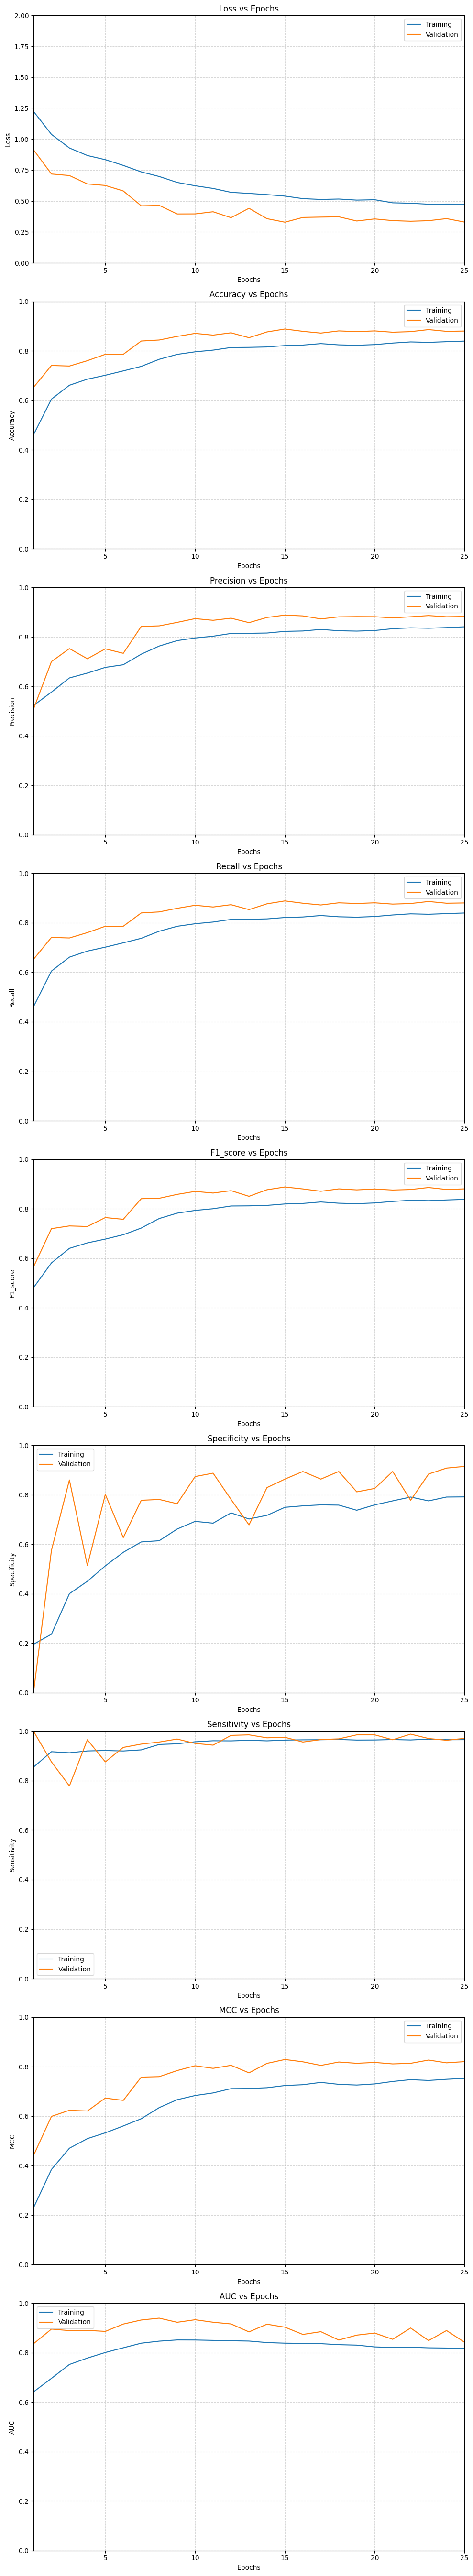

In [19]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [20]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 107/107 [00:05<00:00, 18.33it/s]

Metrics - loss: 0.3940, accuracy: 0.8732, precision: 0.8769, recall: 0.8732, f1_score: 0.8738, specificity: 0.8938, sensitivity: 0.9725, mcc: 0.8102, auc: 0.8366


In [21]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

          COVID     0.8700    0.8938    0.8818       292
   Lung_Opacity     0.8208    0.8765    0.8478       486
         Normal     0.9241    0.8568    0.8892       824
Viral Pneumonia     0.7891    0.9266    0.8523       109

       accuracy                         0.8732      1711
      macro avg     0.8510    0.8884    0.8678      1711
   weighted avg     0.8769    0.8732    0.8738      1711

There were 217 errors in 1711 tests for an accuracy of  87.32


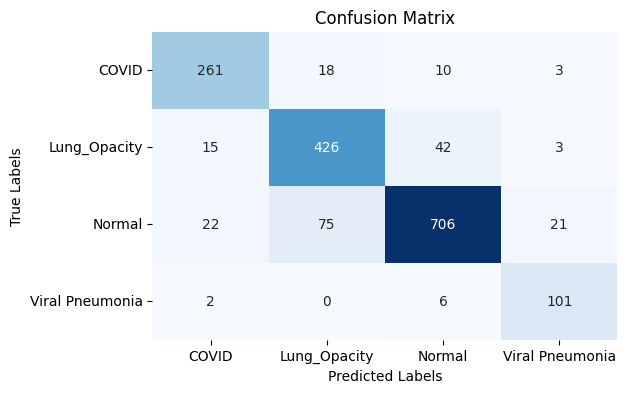

In [22]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()